# Kish Basin exclusions

In [1]:
import os

import cartopy.crs as ccrs
import contextily as cx
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from matplotlib.lines import Line2D
from matplotlib_scalebar.scalebar import ScaleBar

from h2ss import data as rd
from h2ss import functions as fns

In [2]:
# basemap cache directory
cx.set_cache_dir(os.path.join("data", "basemaps"))

## Halite data

In [3]:
ds, extent = rd.kish_basin_data_depth_adjusted(
    dat_path=os.path.join("data", "kish-basin"),
    bathymetry_path=os.path.join("data", "bathymetry"),
)

In [4]:
xmin, ymin, xmax, ymax = extent.total_bounds

## Constraints

### Exploration wells

In [5]:
# 500 m buffer - suggested in draft OREDP II p. 108
wells, wells_b = fns.constraint_exploration_well(
    data_path=os.path.join(
        "data",
        "exploration-wells",
        "Exploration_Wells_Irish_Offshore.shapezip.zip",
    )
)

### Wind farms

In [6]:
# the shapes are used as is without a buffer - suggested for renewable energy
# test site areas in draft OREDP II p. 109
wind_farms = fns.constraint_wind_farm(
    data_path=os.path.join(
        "data", "wind-farms", "wind-farms-foreshore-process.zip"
    ),
    dat_extent=extent,
)

### Frequent shipping routes

In [7]:
# 1 NM (1,852 m) buffer - suggested in draft OREDP II p. 108
shipping, shipping_b = fns.constraint_shipping_routes(
    data_path=os.path.join(
        "data", "shipping", "shipping_frequently_used_routes.zip"
    ),
    dat_extent=extent,
)

### Shipwrecks

In [8]:
# Archaeological Exclusion Zones recommendation - 100 m buffer
shipwrecks, shipwrecks_b = fns.constraint_shipwrecks(
    data_path=os.path.join(
        "data", "shipwrecks", "IE_GSI_MI_Shipwrecks_IE_Waters_WGS84_LAT.zip"
    ),
    dat_extent=extent,
)

### Subsea cables

In [9]:
# 750 m buffer - suggested in draft OREDP II p. 109-111
cables, cables_b = fns.constraint_subsea_cables(
    data_path=os.path.join("data", "subsea-cables", "KIS-ORCA.gpkg")
)

## Crop data layers

In [10]:
# land boundary
land = rd.read_shapefile_from_zip(
    data_path=os.path.join(
        "data", "boundaries", "osi-provinces-ungeneralised-2019.zip"
    )
)

land = land.dissolve().to_crs(rd.CRS)

In [11]:
# create exclusion buffer
buffer = pd.concat([wells_b, shipwrecks_b, shipping_b, cables_b]).dissolve()

In [12]:
# crop land areas from constraints and the buffer
# biospheres = biospheres.overlay(land, how="difference")
shipping = shipping.overlay(land, how="difference")
cables = cables.overlay(land, how="difference")
buffer = buffer.overlay(land, how="difference")

## Map

In [21]:
def plot_map(dat_xr, fontsize=11.5):
    """Helper function to plot constraints and exclusions"""
    # initialise figure
    plt.figure(figsize=(10, 10))
    axis = plt.axes(projection=ccrs.epsg(rd.CRS))

    # halite boundary - use buffering to smooth the outline
    shape = rd.halite_shape(dat_xr=dat_xr).buffer(1000).buffer(-1000)

    # configure map limits
    plt.xlim(shape.bounds["minx"][0] - 10000, shape.bounds["maxx"][0] + 1500)
    plt.ylim(shape.bounds["miny"][0] - 1500, shape.bounds["maxy"][0] + 1500)

    # configure legend entries
    legend_handles = []

    shape.plot(ax=axis, zorder=1, linewidth=0, facecolor="white", alpha=0.35)
    shape.plot(
        ax=axis,
        edgecolor="darkslategrey",
        color="none",
        linewidth=2,
        zorder=3,
    )
    legend_handles.append(
        mpatches.Patch(
            facecolor="none",
            linewidth=2,
            label="Kish Basin boundary",
            edgecolor="darkslategrey",
        )
    )

    # add constraint layers
    for df, hatch, label in zip(
        [buffer.overlay(wind_farms, how="difference"), wind_farms],
        ["//", "xx"],
        ["Exclusion buffer", "Wind farm"],
    ):
        df.plot(
            ax=axis,
            facecolor="none",
            hatch=hatch,
            edgecolor="slategrey",
            zorder=1,
        )
        legend_handles.append(
            mpatches.Patch(
                facecolor="none",
                hatch=hatch,
                edgecolor="slategrey",
                label=label,
            )
        )

    for df, color, linewidth, label in zip(
        [cables, shipping],
        ["tab:blue", "tab:red"],
        [2, 3],
        ["Subsea cable", "Shipping route"],
    ):
        df.plot(ax=axis, color=color, linewidth=linewidth, zorder=2)
        legend_handles.append(
            Line2D([0], [0], color=color, label=label, linewidth=linewidth)
        )

    for df, marker, label in zip(
        [wells, shipwrecks], ["x", "+"], ["Exploration well", "Shipwreck"]
    ):
        df.plot(ax=axis, color="black", marker=marker, zorder=4)
        legend_handles.append(
            Line2D(
                [0],
                [0],
                marker=marker,
                linewidth=0,
                markeredgecolor="black",
                label=label,
            )
        )

    # add basemap and map elements
    basemap = cx.providers.CartoDB.Voyager
    cx.add_basemap(
        axis, crs=rd.CRS, source=basemap, zoom=11, attribution=False
    )
    axis.text(
        shape.bounds["minx"][0] - 9800,
        shape.bounds["miny"][0] - 1300,
        basemap["attribution"],
        fontsize=9.5,
    )

    axis.gridlines(
        draw_labels={"bottom": "x", "left": "y"},
        alpha=0.25,
        color="darkslategrey",
        xformatter=LongitudeFormatter(auto_hide=False, dms=True),
        yformatter=LatitudeFormatter(auto_hide=False, dms=True),
        xlabel_style={"fontsize": fontsize},
        ylabel_style={"fontsize": fontsize, "rotation": 90},
    )
    axis.add_artist(
        ScaleBar(
            1,
            box_alpha=0,
            location="lower right",
            color="darkslategrey",
            font_properties={"size": fontsize},
        )
    )
    plt.legend(
        loc="lower right",
        bbox_to_anchor=(1, 0.05),
        handles=legend_handles,
        fontsize=fontsize,
    )
    plt.title(None)
    plt.tight_layout()
    plt.savefig(
        os.path.join("graphics", "fig_constraints.jpg"),
        format="jpg",
        dpi=600,
    )
    plt.show()

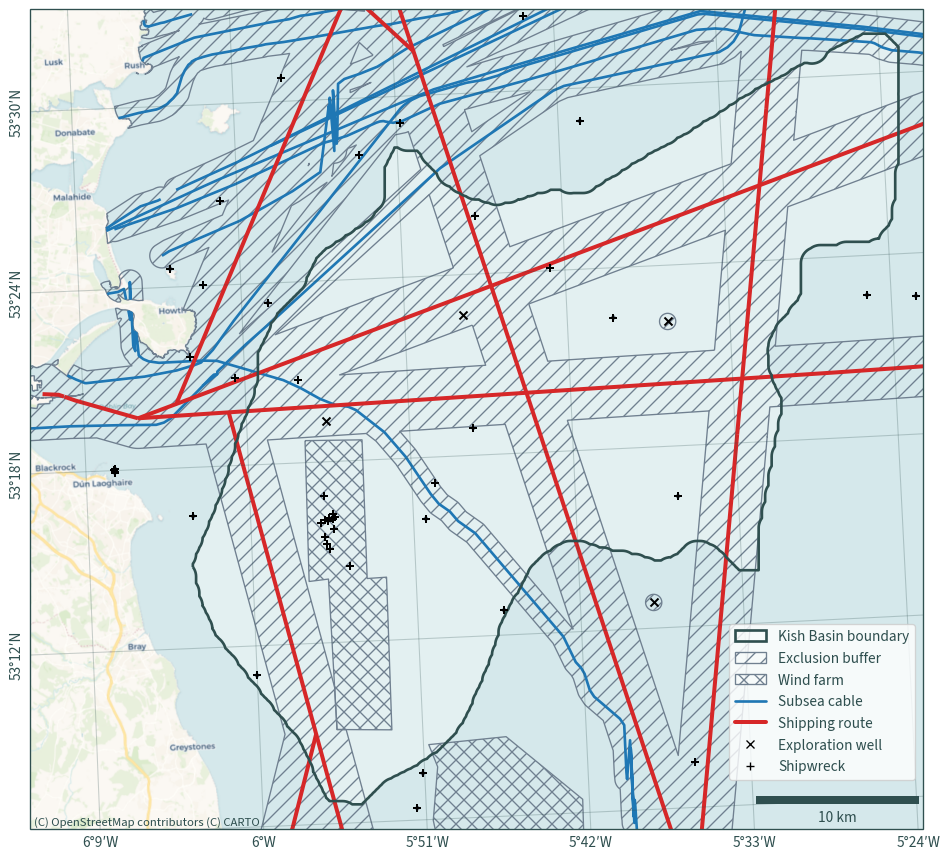

In [22]:
plot_map(ds)